### this is the notebook for messing around to see what i find in the datta

In [5]:
# establishing a connection

import MetaTrader5 as mt5

# 1. Define the path to the FBS EXE file

mt5_path = r"C:\Program Files\FBS MetaTrader 5\terminal64.exe"


print(f"Attempting to connect to: {mt5_path}...")

# 2. Initialize the connection
# We pass the path so Python doesn't look for the generic version
if not mt5.initialize(path=mt5_path):
    print("❌ Connection Failed")
    print("Error Code:", mt5.last_error())
else:
    print("✅ Connection Successful!")
    
    # 3. Print Account Info to prove we are talking to the broker
    account_info = mt5.account_info()
    if account_info:
        print(f"Connected to Account: {account_info.login}")
        # print(f"Connected to Account: {account_info.password}")
        print(f"Server: {account_info.server}")
        print(f"Balance: {account_info.balance} USD")
    
    # 4. Close connection
    mt5.shutdown()

Attempting to connect to: C:\Program Files\FBS MetaTrader 5\terminal64.exe...
✅ Connection Successful!
Connected to Account: 105395845
Server: FBS-Demo
Balance: 20000.0 USD


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [14]:
daily_df = pd.read_parquet('../data/EURUSD_D1.parquet')
daily_df

,open,high,low,close,tick_volume,spread,real_volume
time,,,,,,,
2020-01-02,1.12120,1.12255,1.11640,1.11720,37991,20,0
2020-01-03,1.11720,1.11792,1.11241,1.11540,40083,21,0
2020-01-06,1.11630,1.12058,1.11565,1.11955,33765,21,0
2020-01-07,1.11948,1.11978,1.11327,1.11518,36622,15,0
2020-01-08,1.11514,1.11675,1.10998,1.11039,52731,15,0
...,...,...,...,...,...,...,...
2025-12-16,1.17495,1.18040,1.17343,1.17474,60266,8,0
2025-12-17,1.17450,1.17581,1.17030,1.17399,59217,8,0
2025-12-18,1.17378,1.17629,1.17122,1.17240,59197,8,0


In [15]:
daily_df.columns

Index(['open', 'high', 'low', 'close', 'tick_volume', 'spread', 'real_volume'], dtype='object')

In [16]:
daily_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1552 entries, 2020-01-02 to 2025-12-22
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   open         1552 non-null   float64
 1   high         1552 non-null   float64
 2   low          1552 non-null   float64
 3   close        1552 non-null   float64
 4   tick_volume  1552 non-null   uint64 
 5   spread       1552 non-null   int32  
 6   real_volume  1552 non-null   uint64 
dtypes: float64(4), int32(1), uint64(2)
memory usage: 90.9 KB


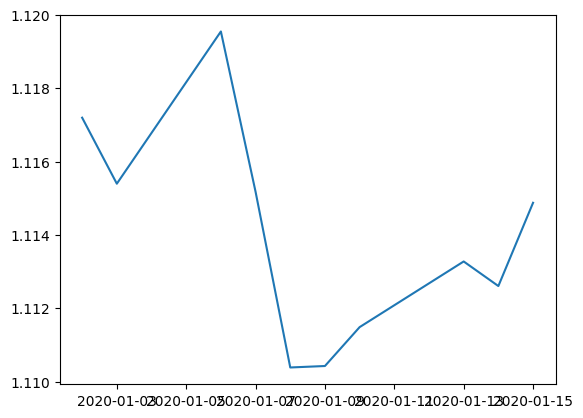

In [12]:
plt.plot(daily_df.loc['2020-01-02' : '2020-01-15']['close'])

In [36]:
# Cell 1: Imports
import pandas as pd
import numpy as np
# import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Configuration
# If you are continuing directly from the previous cell, use df_feat.
# If loading from disk, uncomment the line below:
df_feat = pd.read_parquet("../data/engineered_features_16h.parquet")

print(f"Data Shape: {df_feat.shape}")

Data Shape: (9101, 53)


In [37]:
# df_feat.columns.to_list()

In [38]:
# Cell 2: Prepare X and y

# 1. Define Target
# Copy the label to ensure we don't modify the original dataframe in place unexpectedly later
y = df_feat['label'].copy()

# 2. Map Labels for XGBoost/Model Compatibility
# Current: -1 (Sell), 0 (Range), 1 (Buy)
# Mapped:   0 (Sell), 1 (Range), 2 (Buy)
label_mapping = {-1: 0, 0: 1, 1: 2}
y_mapped = y.map(label_mapping)

# 3. Define Features (X)
# List of columns to drop (cleaned of syntax errors)
drop_cols = [
    'sess_tokyo_london', 'sess_asian_lunch', 'label', 
    'open', 'high', 'low', 'close', 
    'tick_volume', 'spread', 'atr',
    'rsi_7', 'rsi_21',
    'sess_dead_zone', 'sess_ny', 'sess_london', 
    'sess_sydney', 'hour_sin', 'day_cos',
    'roll_kurt_20'
]

# Calculate the intersection to avoid KeyErrors if a column is already missing
cols_to_drop = [c for c in drop_cols if c in df_feat.columns]

# Create the feature matrix X
X = df_feat.drop(columns=cols_to_drop)

print(f"Features (X) Shape: {X.shape}")
print(f"Target (y) Shape: {y_mapped.shape}")
print(f"Class Balance:\n{y_mapped.value_counts(normalize=True)}")

Features (X) Shape: (9101, 34)
Target (y) Shape: (9101,)
Class Balance:
label
1    0.508296
2    0.246896
0    0.244808
Name: proportion, dtype: float64


In [39]:
# Cell 3: Chronological Split

# We'll use the first 80% for training, last 20% for validation
split_point = int(len(X) * 0.80)

X_train = X.iloc[:split_point]
X_test = X.iloc[split_point:]

y_train = y_mapped.iloc[:split_point]
y_test = y_mapped.iloc[split_point:]

print(f"Training Samples: {len(X_train)} (Start: {X_train.index[0]} - End: {X_train.index[-1]})")
print(f"Testing Samples:  {len(X_test)}  (Start: {X_test.index[0]} - End: {X_test.index[-1]})")

Training Samples: 7280 (Start: 2020-02-20 14:00:00 - End: 2024-10-22 18:00:00)
Testing Samples:  1821  (Start: 2024-10-22 22:00:00 - End: 2025-12-24 02:00:00)


In [42]:
import contextlib
import joblib
from tqdm.auto import tqdm

@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar"""
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint, uniform

# ==========================================
# 1. SETUP DATA (Assuming X and y are ready)
# ==========================================
# X = df[features]
# y = df['target'] (Values: -1, 0, 1 or "Sell", "Range", "Buy")

# ==========================================
# 2. THE "NO COMPROMISE" CONFIGURATION
# ==========================================

# A. The Validation Strategy
# STRICT Time Series Split. 
# We use 5 splits with a gap to prevent leakage between train/test windows.
tscv = TimeSeriesSplit(n_splits=5, gap=50) 

# B. The Search Space (Probability Distributions)
# We use distributions to find the "Sweet Spot" mathematically.
param_dist = {
    # TREES: More is usually better but diminishing returns. 
    # We search 200-800 to find the stability point.
    'n_estimators': randint(200, 800),

    # DEPTH: The most critical setting for overfitting.
    # A range of 3-12 forces the model to simplify its logic. 
    # If it needs depth 20, it's memorizing noise.
    'max_depth': randint(3, 12),

    # CONFIDENCE: min_samples_leaf ensures a rule applies to many samples.
    # We look for leaves containing 20 to 100 samples.
    # This prevents the model from creating a rule for just 1-2 specific candles.
    'min_samples_leaf': randint(20, 100),

    # RANDOMNESS: Helps decorrelate trees
    'max_features': ['sqrt', 'log2'],

    # CRITICAL: CLASS WEIGHTS
    # 'balanced_subsample' calculates weights for EACH bootstrap sample.
    # This aggressively penalizes the model for ignoring Buy/Sell signals.
    'class_weight': ['balanced', 'balanced_subsample'],
    
    # QUALITY: Gini is faster, Entropy sometimes finds better gradients.
    'criterion': ['gini', 'entropy']
}

# ==========================================
# 3. EXECUTION
# ==========================================
print("Starting SOTA Hyperparameter Optimization...")

rf = RandomForestClassifier(n_jobs=-1, random_state=42)

search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=100,              # 100 unique combinations (High compute, high confidence)
    scoring='f1_macro',      # CRITICAL: Optimizes for the AVERAGE score of all classes (Buy/Sell/Range)
    cv=tscv,                 # Respects time order
    # n_jobs=-1,               # Uses all CPU cores
    verbose=1,
    random_state=42,
    return_train_score=True  # Lets us check for overfitting later
)

# --- EXECUTION WITH PROGRESS BAR ---

# 1. Calculate total jobs for the progress bar
# Total jobs = n_iter * number of splits in your CV
total_jobs = 100 * 5  # Based on n_iter=100 and TimeSeriesSplit(n_splits=5)

print(f"Starting SOTA Hyperparameter Optimization ({total_jobs} total fits)...")

# 2. Run the search with the progress bar
with tqdm_joblib(tqdm(desc="Optimizing", total=total_jobs)) as progress_bar:
    search.fit(X, y)

# 3. Done
print("\nOptimization Complete.")
print(f"Best Score (Macro F1): {search.best_score_:.4f}")
print(search.best_params_)


# Train the final "Best" model on the most recent data chunk to see specific metrics
best_model = search.best_estimator_

# If you want to see if we fixed the Class Imbalance:
from sklearn.metrics import classification_report
# Note: In a real backtest, you would evaluate this on a hold-out "future" set.
# For now, we inspect the best model's behavior on the last split of data.
test_index = list(tscv.split(X))[-1][1] 
X_test_last, y_test_last = X.iloc[test_index], y.iloc[test_index]
y_pred = best_model.predict(X_test_last)

print("\n--- FINAL VALIDATION (Last Split) ---")
print(classification_report(y_test_last, y_pred))

Starting SOTA Hyperparameter Optimization...
Starting SOTA Hyperparameter Optimization (500 total fits)...


Optimizing:   0%|          | 0/500 [00:00<?, ?it/s]

Fitting 5 folds for each of 100 candidates, totalling 500 fits


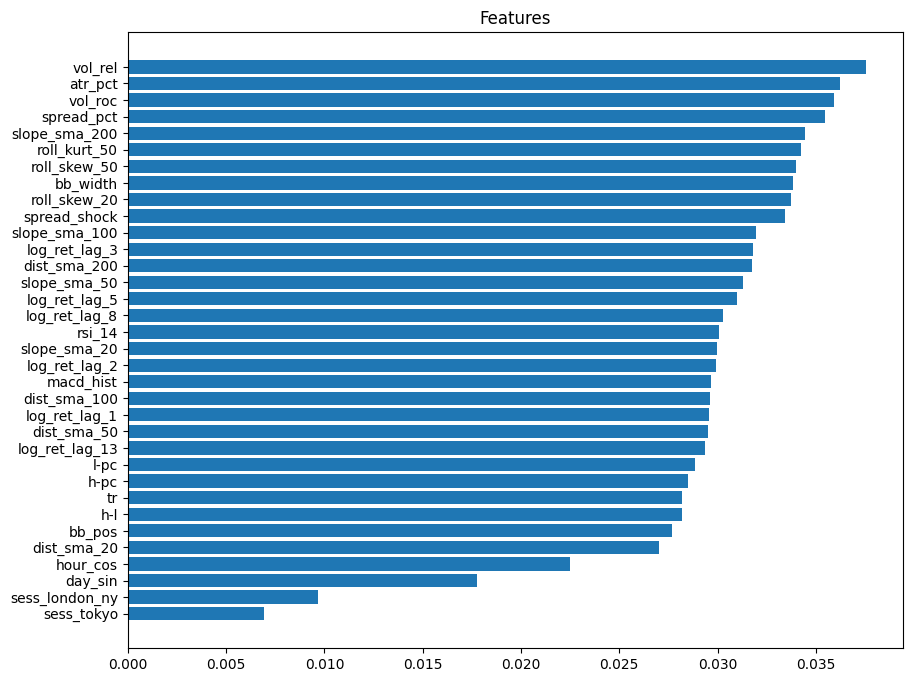

           Feature  Importance
10         vol_rel    0.037549
17         atr_pct    0.036232
11         vol_roc    0.035945
8       spread_pct    0.035491
27   slope_sma_200    0.034452
16    roll_kurt_50    0.034244
15    roll_skew_50    0.033967
12        bb_width    0.033827
14    roll_skew_20    0.033755
9     spread_shock    0.033413
25   slope_sma_100    0.031945
30   log_ret_lag_3    0.031806
26    dist_sma_200    0.031765
23    slope_sma_50    0.031303
31   log_ret_lag_5    0.031009
32   log_ret_lag_8    0.030270
18          rsi_14    0.030071
21    slope_sma_20    0.029970
29   log_ret_lag_2    0.029931
19       macd_hist    0.029681
24    dist_sma_100    0.029624
28   log_ret_lag_1    0.029577
22     dist_sma_50    0.029512
33  log_ret_lag_13    0.029386
2             l-pc    0.028860
1             h-pc    0.028506
3               tr    0.028201
0              h-l    0.028192
13          bb_pos    0.027698
20     dist_sma_20    0.027013
4         hour_cos    0.022485
5       

In [32]:

# 2. Extract Feature Importance
importances = model.feature_importances_
feature_names = X_train.columns

# 3. Create a DataFrame and Sort
feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

# 4. Visualize
plt.figure(figsize=(10, 8))
plt.barh(feat_df['Feature'], feat_df['Importance']) # Top 20
plt.gca().invert_yaxis()
plt.title("Features")
plt.show()

# 5. The "Kill List"
# print("Bottom 10 Features (Likely Noise):")
print(feat_df)